In [2]:
import atlite
import geopandas as gpd

import hvplot.xarray
import hvplot.pandas
import holoviews as hv

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import os
from matplotlib.gridspec import GridSpec
#import seaborn as sns
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from cartopy.crs import PlateCarree as plate

import xarray as xr

import logging
import warnings

import numpy as np

warnings.simplefilter("ignore")
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

# Load Geodata
load you regions to which you want to aggregate the wind speeds from the "input_data" folder

In [3]:
dirname = os.getcwd()

#load geodata
model_areas_file = os.path.join(dirname,'input_data',"ADM1_GADM.geojson")
model_areas = gpd.read_file(model_areas_file).set_index("NAME_1")

country_file = os.path.join(dirname,'input_data',"EG_adm0.geojson")
country = gpd.read_file(country_file, crs=4326).set_index("COUNTRY")

# Load and process the cutout

In [4]:
#load cutout 
cutout = atlite.Cutout(os.path.join(dirname,'input_data',"egypt-2015-wind2-era5.nc"))

#access cutout data
cutout.data

<xarray.Dataset> Size: 203MB
Dimensions:      (x: 47, y: 41, time: 8760)
Coordinates:
  * x            (x) float64 376B 24.75 25.0 25.25 25.5 ... 35.75 36.0 36.25
  * y            (y) float64 328B 21.75 22.0 22.25 22.5 ... 31.25 31.5 31.75
  * time         (time) datetime64[ns] 70kB 2015-01-01 ... 2015-12-31T23:00:00
    lon          (x) float64 376B dask.array<chunksize=(47,), meta=np.ndarray>
    lat          (y) float64 328B dask.array<chunksize=(41,), meta=np.ndarray>
Data variables:
    wnd100m      (time, y, x) float32 68MB dask.array<chunksize=(100, 41, 47), meta=np.ndarray>
    wnd_azimuth  (time, y, x) float32 68MB dask.array<chunksize=(100, 41, 47), meta=np.ndarray>
    roughness    (time, y, x) float32 68MB dask.array<chunksize=(100, 41, 47), meta=np.ndarray>
Attributes:
    module:                  era5
    prepared_features:       wind
    chunksize_time:          100
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-13T18:24 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
#get max wind speed over all dimensions
max_wind_speed = float(cutout.data['wnd100m'].max().compute())
max_wind_speed

23.398418426513672

Text(16417.752083333333, 5.796760082244873, 'mean wind speed = 5.80')

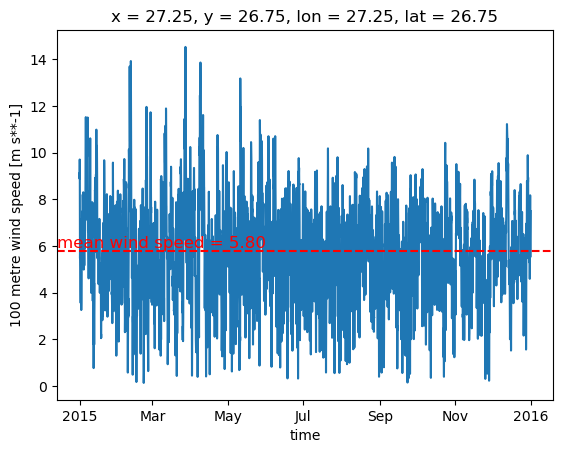

In [6]:
#access the wind speed data of a certain pixel
x=10
y=20
wind_pixel = cutout.data['wnd100m'].isel(x=x, y=y)
# Plot the wind speed over time
wind_pixel.plot.line()
#add mean wind speed
mean_wind_speed_pixel = cutout.data.wnd100m.mean(dim="time").isel(x=x, y=y).values
plt.axhline(y=mean_wind_speed_pixel, color='r', linestyle='--', label=f'mean wind speed')
plt.text(x=plt.xlim()[0], y=mean_wind_speed_pixel, s=f'mean wind speed = {mean_wind_speed_pixel:.2f}', 
         color='r', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

In [7]:
#standards for all plots
projection = ccrs.Orthographic(central_longitude=30, central_latitude=30)
cells = cutout.grid
cutout_bound = gpd.GeoSeries(cells.unary_union)

Text(0.5, 1.0, 'mean windspeed over the whole country')

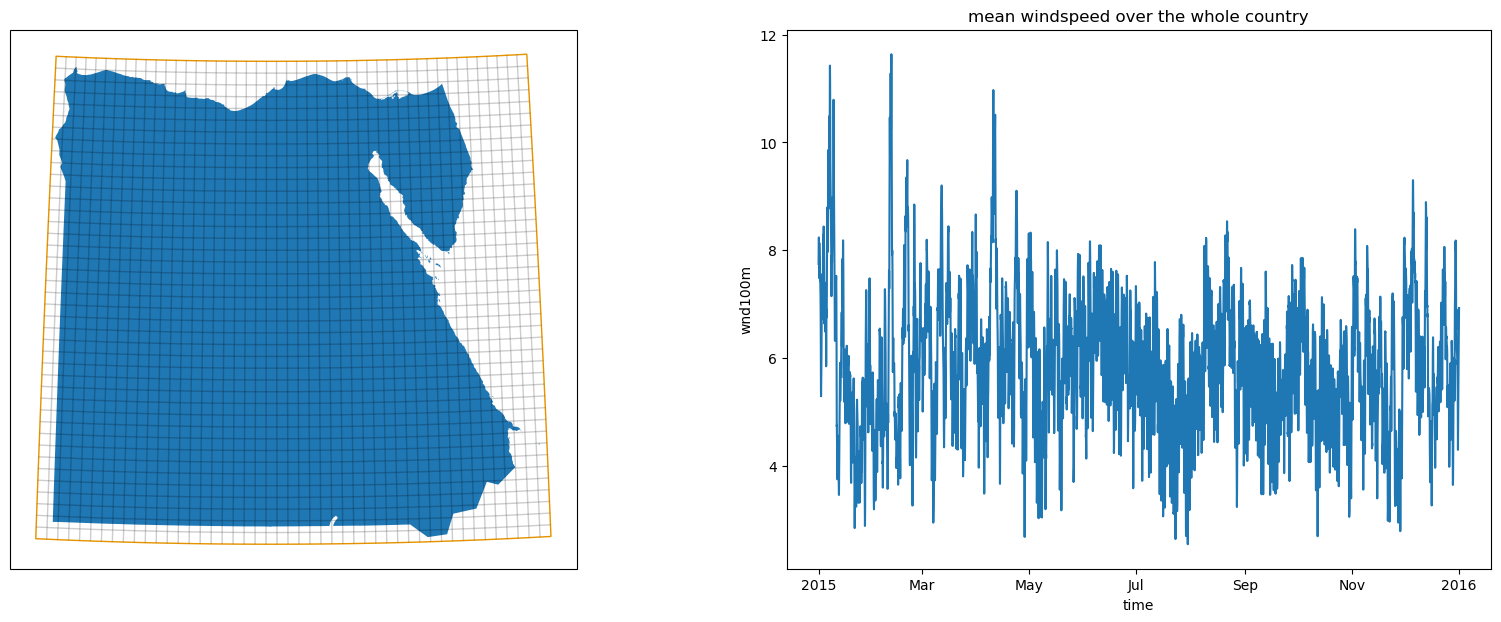

In [8]:
#plot country and mean windspeed over whole country for overview
#cartopy approach --> projections and transformation
fig = plt.figure(figsize=(20, 7))
gs = GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0], projection=projection)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
)
country.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
cutout_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
#country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
#ax.outline_patch.set_edgecolor("white")

ax1 = fig.add_subplot(gs[0, 1])
cutout.data.wnd100m.mean(["x", "y"]).plot(ax=ax1)
ax1.set_title('mean windspeed over the whole country')
#ax1.set_frame_on(False)
#ax1.xaxis.set_visible(False)

In [9]:
#interactive plot mean wind speed over whole year for each pixel
wnd100mean = cutout.data.wnd100m.mean(dim="time")

quadmesh_plot = wnd100mean.hvplot.quadmesh(
    "x",
    "y",
    "wnd100m",
    frame_height=500,
    cmap="viridis",
    geo=True,
    tiles="CartoLight",
    alpha=0.8,
    padding=0.5,
    clim=(0, 10),
    title='mean windspeed @100m',
    hover_cols=['x', 'y', 'wnd100m'],  # Include x, y, and wind speed in hover
)

polygon_plot = model_areas.hvplot(
    geo=True,
    line_color='red',        # Set color of polygons, e.g., red
    fill_alpha=0,          # Transparency level of polygons
    line_width=1.5,     # Line width for borders of polygons
)

# Overlaying the quadmesh plot with the polygon plot
overlay = quadmesh_plot * polygon_plot

# Display the final overlay plot
overlay

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .QuadMesh.I :QuadMesh   [x,y]   (wnd100m,x,y,wnd100m)
   .Polygons.I :Polygons   [Longitude,Latitude]

<GeoAxes: xlabel='x', ylabel='y'>

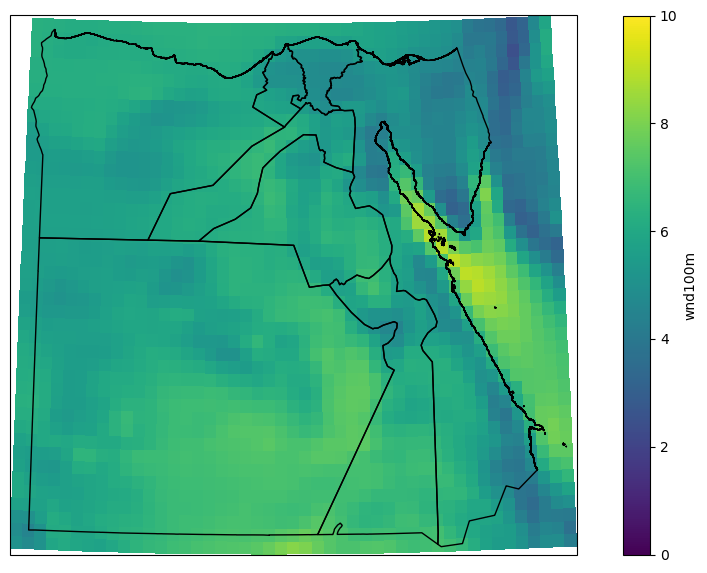

In [10]:
#static plot mean wind speed over whole year for each pixel
fig = plt.figure(figsize=(12, 7))

ax = plt.axes(projection=projection)
wnd100mean.plot(ax=ax, vmin=0, vmax=10, transform=plate())

#shape.to_crs(crs).plot(ax=ax, edgecolor="k", color="None")
model_areas.to_crs(projection.proj4_init).plot(ax=ax, edgecolor="k", color="None")
#shape.plot(ax=ax, edgecolor="k", color="None", transform=plate())

#ax.set_extent([70, 75, 18, 25], crs=crs)

#import cartopy
#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#ax.add_feature(cartopy.feature.LAND, color="cornsilk")
#ax.add_feature(cartopy.feature.OCEAN, color="azure")


# aggregate wind speed timeseries per model area

In [11]:
#check data structure of wind turbine to define helper turbine
atlite.resource.get_windturbineconfig('NREL_ReferenceTurbine_5MW_offshore')

{'V': array([ 0,  3,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 25, 25]),
 'POW': array([0.    , 0.    , 0.0405, 0.1777, 0.4039, 0.7376, 1.1872, 1.7711,
        2.5186, 3.4484, 4.5625, 5.    , 5.    , 0.    ]),
 'hub_height': 90.0,
 'P': 5.0}

In [12]:
#create helper power curve where wind speeds are mapped to themselves, the nameplate capacity of this helper_turbine is the max_wind_speed to have later values normalized to this wind speed 
# get like a hourly CF timeseries where 1 equals to the max_wind_speed 
wind_speed = np.arange(0, 31, 1)

#helper_turbine = {'hub_height':100, 'V':wind_speed, 'POW':wind_speed_power, 'P':max_wind_speed}

#wind_speed = [0,100]
helper_turbine = {'V':wind_speed, 'POW':wind_speed, 'hub_height':100, 'P':max_wind_speed}



In [13]:
#check helper turbine
atlite.resource.get_windturbineconfig(helper_turbine)

highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.


{'V': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 'POW': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 'hub_height': 100,
 'P': 23.398418426513672}

In [14]:
#do the aggregation
windspeed_aggregated_areas = cutout.wind(helper_turbine, per_unit=True, shapes=model_areas) #, layout=layout) #Vestas_V112_3MW #capacity_factor=True

highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.
INFO:atlite.convert:Convert and aggregate 'wind'.


# Inspect the results 

In [15]:
#turn results into pandas dataframe for easier handling
results = (windspeed_aggregated_areas).to_pandas()#.rename_axis(index="", columns="shapes")
results = results*max_wind_speed
results

NAME_1,Ad Daqahliyah,Al Bahr al Ahmar,Al Buhayrah,Al Fayyum,Al Gharbiyah,Al Iskandariyah,Al Isma`iliyah,Al Jizah,Al Minufiyah,Al Minya,...,Asyut,Bani Suwayf,Bur Sa`id,Dumyat,Janub Sina',Kafr ash Shaykh,Matrouh,Qina,Shamal Sina',Suhaj
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,8.014813,3.885446,10.090580,9.711392,8.267582,10.536083,6.600270,9.794365,9.131714,9.326081,...,7.728687,8.087367,6.911347,8.265633,2.910694,9.300647,10.936232,3.159858,2.886183,7.718327
2015-01-01 01:00:00,8.529795,3.737078,10.088891,9.721022,8.724714,10.394765,7.588720,9.526174,9.606460,9.481600,...,8.592743,8.211595,7.966138,9.140216,2.966773,9.801356,10.862875,4.458675,3.442479,8.317759
2015-01-01 02:00:00,8.765107,3.709027,9.698153,9.290012,8.710676,9.986391,8.467581,9.458969,9.368352,9.461007,...,9.555076,8.026683,8.839189,9.719865,3.438590,9.834723,10.764534,5.260427,4.196945,9.027237
2015-01-01 03:00:00,8.498969,3.779743,9.612741,8.579469,8.419065,10.004517,8.318015,9.516153,8.979213,9.230622,...,10.061034,7.431543,8.988551,9.659669,4.347166,9.599911,10.416473,5.784425,5.137359,10.022393
2015-01-01 04:00:00,8.559014,3.856215,9.642520,8.600305,8.609261,9.926267,7.861222,9.432649,9.186603,9.226278,...,9.948728,7.195917,8.901257,9.647852,5.094939,9.765414,9.934568,6.362505,5.930164,10.485413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 19:00:00,6.855069,6.351314,6.183297,6.428906,5.767122,7.761518,7.159490,7.298728,5.148246,6.580834,...,6.201127,6.213394,7.964819,9.117961,4.729443,8.489924,7.357639,5.870566,7.382458,5.356277
2015-12-31 20:00:00,7.407920,6.646217,6.536282,5.933027,6.180504,8.289528,7.319722,7.146313,5.516989,6.886335,...,6.677167,5.901551,8.531263,9.920721,5.223405,8.667598,7.230464,5.840545,8.123178,5.593341
2015-12-31 21:00:00,7.635354,6.802980,6.793392,5.726448,6.274085,8.430972,7.220106,7.125775,5.814761,7.028651,...,6.982540,5.586364,9.125516,10.176901,5.641383,8.840668,7.033302,5.541763,8.762525,5.959396


Text(394464.0, 4.775612133496767, 'mean wind speed = 4.78')

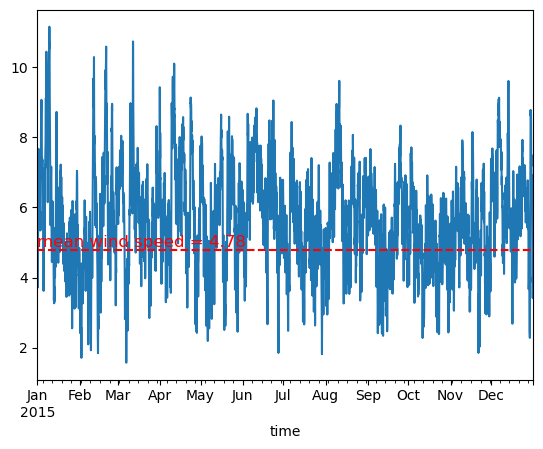

In [16]:
#plot selected region
results[r"Al Bahr al Ahmar"].plot()
#add mean wind speed
mean_wind_speed_area = results[r"Janub Sina'"].mean()
plt.axhline(y=mean_wind_speed_area, color='r', linestyle='--', label=f'mean wind speed')
plt.text(x=plt.xlim()[0], y=mean_wind_speed_area, s=f'mean wind speed = {mean_wind_speed_area:.2f}', 
         color='r', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

In [17]:
#get max wind speeds after aggregation 
print('overall total: ', results.max().max())

results.max()

overall total:  18.843952754230507


NAME_1
Ad Daqahliyah       16.463813
Al Bahr al Ahmar    11.151284
Al Buhayrah         17.427164
Al Fayyum           16.368891
Al Gharbiyah        15.841305
Al Iskandariyah     18.316246
Al Isma`iliyah      18.843953
Al Jizah            16.877938
Al Minufiyah        16.799763
Al Minya            15.388925
Al Qahirah          18.233768
Al Qalyubiyah       16.781395
Al Uqsur            11.625927
Al Wadi al Jadid    12.097451
As Suways           17.357652
Ash Sharqiyah       16.813030
Aswan               12.594253
Asyut               14.448930
Bani Suwayf         16.185089
Bur Sa`id           18.322068
Dumyat              18.063010
Janub Sina'         13.576892
Kafr ash Shaykh     17.755131
Matrouh             17.669122
Qina                11.747417
Shamal Sina'        17.992652
Suhaj               13.449881
dtype: float64

In [18]:
results.mean()

NAME_1
Ad Daqahliyah       4.956129
Al Bahr al Ahmar    5.661495
Al Buhayrah         5.410236
Al Fayyum           5.667672
Al Gharbiyah        4.826286
Al Iskandariyah     5.595159
Al Isma`iliyah      5.054013
Al Jizah            6.122250
Al Minufiyah        5.076361
Al Minya            6.236538
Al Qahirah          5.449433
Al Qalyubiyah       4.899447
Al Uqsur            5.130879
Al Wadi al Jadid    6.290606
As Suways           4.732743
Ash Sharqiyah       4.810706
Aswan               6.624175
Asyut               6.181840
Bani Suwayf         5.916366
Bur Sa`id           5.366852
Dumyat              5.415076
Janub Sina'         4.775612
Kafr ash Shaykh     5.291653
Matrouh             5.850672
Qina                5.457428
Shamal Sina'        4.655072
Suhaj               6.119240
dtype: float64